In [1]:
# variables

USER = 'ppossemiers'
BASE_PATH = '../data/analyzer/'
REPO_PATH = 'netty-4.1'
#REPO_PATH = 'test'
STOP_LINES = ['*', '//', 'import', 'package', '{', '}', '@']
STOP_WORDS = ['abstract','continue','for','new','switch','assert','default','goto','synchronized',
            'boolean','do','if','private','this','break','double','implements','protected','throw',
            'byte','else','public','throws','case','enum','instanceof','return','transient',
            'catch','extends','int','short','try','char','final','interface','static','void',
            'class','finally','long','strictfp','volatile','const','float','native','super','while'
            'true','false','null']

In [8]:
# imports and directives

%matplotlib inline
from pyspark import SparkContext
import os, re, requests, zipfile, json
from StringIO import StringIO
import operator
from pyspark.ml.feature import Tokenizer, RegexTokenizer, HashingTF, IDF
import matplotlib.pyplot as plt
from numpy import *

In [ ]:
search_url = 'https://api.github.com/search/repositories?q=' + 'user:' + USER
result = requests.get(search_url)
repos = json.loads(result.content)['items']

for repo in repos:
    url = 'https://github.com/' + repo['full_name'] + '/archive/master.zip'
    dir_name = BASE_PATH + repo['full_name'] + '/'
    if not os.path.exists(dir_name):
        os.makedirs(dir_name)

    zip = requests.get(url)
    zipdata = StringIO()
    zipdata.write(zip.content)

    with zipfile.ZipFile(zipdata, 'r') as z:
        z.extractall(dir_name)

In [9]:
def all_files(directory):
    for path, dirs, files in os.walk(directory):
        for f in files:
            yield os.path.join(path, f)

def sanitize(contents):
    lines = contents.split('\n')

    # remove stop lines
    for stop_line in STOP_LINES:
        lines = [line.lower().lstrip().replace(';', '') for line in lines if stop_line not in line and line <> '']

    # remove stop words
    for stop_word in STOP_WORDS:
        # replace() doesn't work because variables get mangled
        lines = [re.sub(r'\b%s\b' % stop_word, '', line) for line in lines]
    
    # remove operators
    lines = [line.replace('=', '').replace('+', '')
             .replace('-', '').replace('>', '')
             .replace('<', '').replace('|', '')
             .replace('%', '') for line in lines]
    
    # join all lines into one string
    return ' '.join(lines)

def count_dependencies(src):
    names, codes = zip(*src)
    deps = {e : 0 for i, e in enumerate(names)}

    for name in names:
        for code in codes:
            if name in code:
                deps[name] += 1
    
    # sort by amount of references
    #return sorted(deps.items(), key=operator.itemgetter(1), reverse=True)
    return {k: v for k, v in deps.iteritems() if v > 1}

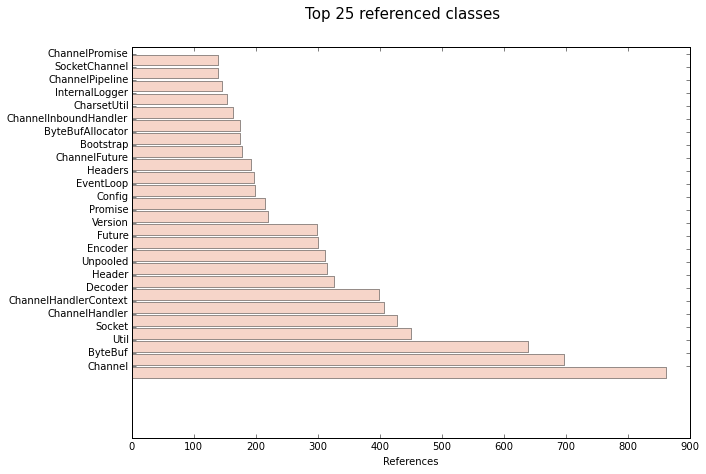

In [11]:
joined = []
# get all java source files
src_files = [f for f in all_files(BASE_PATH + REPO_PATH) if f.endswith('.java')]

for n in src_files:
    # create tuple of classname and contents of file
    # plain read is used to avoid broadcasting the spark context
    joined.append((os.path.basename(n).split('.')[0], open(n, 'r').read()))

deps = count_dependencies(joined)

# show top referenced classes
refs = sorted(deps.values(), reverse=True)[:25]
lbls = sorted(deps, key=deps.get, reverse=True)[:25]
# make plot
fig = plt.figure(figsize=(10, 7))
fig.suptitle('Top 25 referenced classes', fontsize=15)
ax = fig.add_subplot(111)
ax.barh(y_pos, refs, align='center', alpha=0.4, color='darksalmon')
#set ticks
y_pos = np.arange(len(lbls)) + 0.5
ax.set_yticks(y_pos)
ax.set_yticklabels(lbls)
ax.set_xlabel('References')

plt.show()

In [ ]:
joined_rdd = sc.parallelize(joined)
# make tuple of (class_name, sanitized code) for each source file
sanitized = joined_rdd.map(lambda tup: (tup[0], sanitize(tup[1])))

sanitized_df = sqlContext.createDataFrame(sanitized, ['label', 'code'])
tokenizer = Tokenizer(inputCol='code', outputCol='words')
words_df = tokenizer.transform(sanitized_df)

#for words_label in words_df.select('words', 'label').take(2):
#    print(words_label)

hashingTF = HashingTF(inputCol='words', outputCol='rawFeatures', numFeatures=5)
featurizedData = hashingTF.transform(words_df)

idf = IDF(inputCol='rawFeatures', outputCol='features')
idfModel = idf.fit(featurizedData)
rescaledData = idfModel.transform(featurizedData)

for features_label in rescaledData.select('features', 'label').take(3):
    print(features_label)

In [ ]:
import scala.collection.mutable
import org.apache.spark.mllib.clustering.LDA
import org.apache.spark.mllib.linalg.{Vector, Vectors}
import org.apache.spark.rdd.RDD

// Load documents from text files, 1 document per file
val corpus: RDD[String] = sc.wholeTextFiles("docs/*.md").map(_._2)

// Split each document into a sequence of terms (words)
val tokenized: RDD[Seq[String]] =
  corpus.map(_.toLowerCase.split("\\s")).map(_.filter(_.length > 3).filter(_.forall(java.lang.Character.isLetter)))

// Choose the vocabulary.
//   termCounts: Sorted list of (term, termCount) pairs
val termCounts: Array[(String, Long)] =
  tokenized.flatMap(_.map(_ -> 1L)).reduceByKey(_ + _).collect().sortBy(-_._2)
//   vocabArray: Chosen vocab (removing common terms)
val numStopwords = 20
val vocabArray: Array[String] =
  termCounts.takeRight(termCounts.size - numStopwords).map(_._1)
//   vocab: Map term -> term index
val vocab: Map[String, Int] = vocabArray.zipWithIndex.toMap

// Convert documents into term count vectors
val documents: RDD[(Long, Vector)] =
  tokenized.zipWithIndex.map { case (tokens, id) =>
    val counts = new mutable.HashMap[Int, Double]()
    tokens.foreach { term =>
      if (vocab.contains(term)) {
        val idx = vocab(term)
        counts(idx) = counts.getOrElse(idx, 0.0) + 1.0
      }
    }
    (id, Vectors.sparse(vocab.size, counts.toSeq))
  }

// Set LDA parameters
val numTopics = 10
val lda = new LDA().setK(numTopics).setMaxIterations(10)

val ldaModel = lda.run(documents)
val avgLogLikelihood = ldaModel.logLikelihood / documents.count()

// Print topics, showing top-weighted 10 terms for each topic.
val topicIndices = ldaModel.describeTopics(maxTermsPerTopic = 10)
topicIndices.foreach { case (terms, termWeights) =>
  println("TOPIC:")
  terms.zip(termWeights).foreach { case (term, weight) =>
    println(s"${vocabArray(term.toInt)}\t$weight")
  }
  println()
}